In [53]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [54]:
RAW_DATA_PATH = "census.csv"
CLEANED_DATA_PATH = "cleaned_census.csv"

In [55]:
raw_df = pd.read_csv(RAW_DATA_PATH)
raw_df.sample(3)

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
20771,23,Private,210526,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
30828,61,Local-gov,195519,Masters,14,Never-married,Prof-specialty,Unmarried,White,Female,0,0,25,United-States,<=50K
21394,22,?,121070,Some-college,10,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K


In [56]:
# Remove spaces in columns name
raw_df = raw_df.rename(columns = lambda x: x.strip())

# Remove spaces in values
raw_df = raw_df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)

# Remove duplicates
raw_df = raw_df.drop_duplicates()

### **EDA**

In [57]:
raw_df.dtypes

age                int64
workclass         object
fnlgt              int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [58]:
raw_df["salary"].value_counts()

salary
<=50K    24698
>50K      7839
Name: count, dtype: int64

In [59]:
np.arange(int(raw_df.age.min()), int(raw_df.age.max()), 5)

array([17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87])

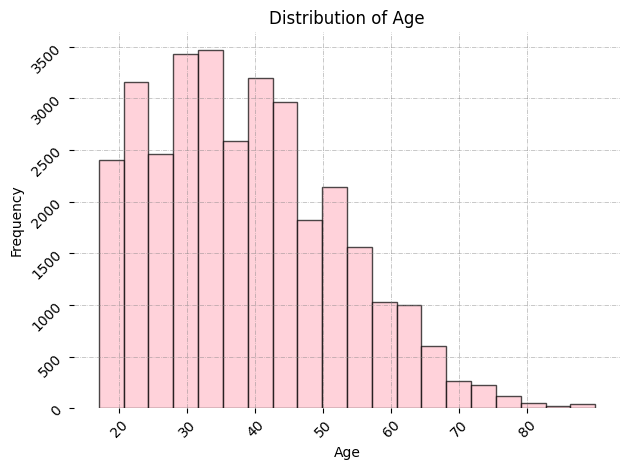

In [60]:
# Create the histogram plot
plt.hist(raw_df.age, 
        bins=20, 
        edgecolor='black',
        alpha=0.7, 
        color='pink')

# Set the plot labels and title
plt.xlabel('Age')
plt.xticks(np.arange(round(
                        raw_df.age.min()/10)*10, 
                        round(raw_df.age.max()/10)*10, 
                        10), 
                     rotation=45)

plt.ylabel('Frequency')
plt.yticks(rotation=45)

plt.title('Distribution of Age')

plt.grid(color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Optimize Plot Layout
plt.tight_layout()

# Show the plot
plt.show()

Almost age is in the range from 20 - 52

In [61]:
raw_df[raw_df['salary']==">50K"]['workclass'].value_counts().sort_index()

workclass
?                    191
Federal-gov          371
Local-gov            617
Private             4961
Self-emp-inc         622
Self-emp-not-inc     724
State-gov            353
Name: count, dtype: int64

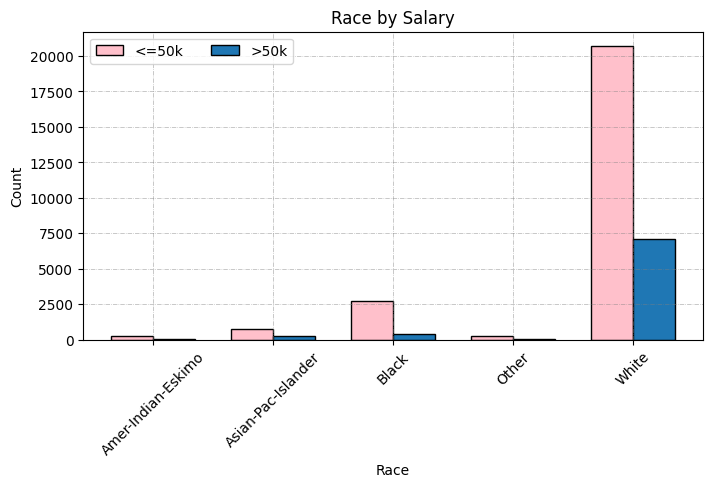

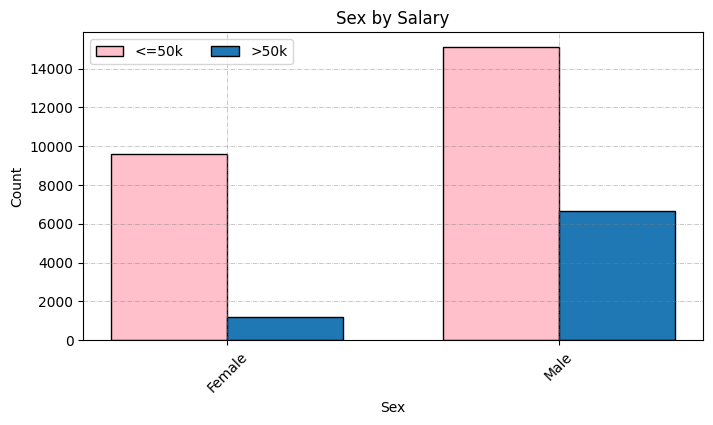

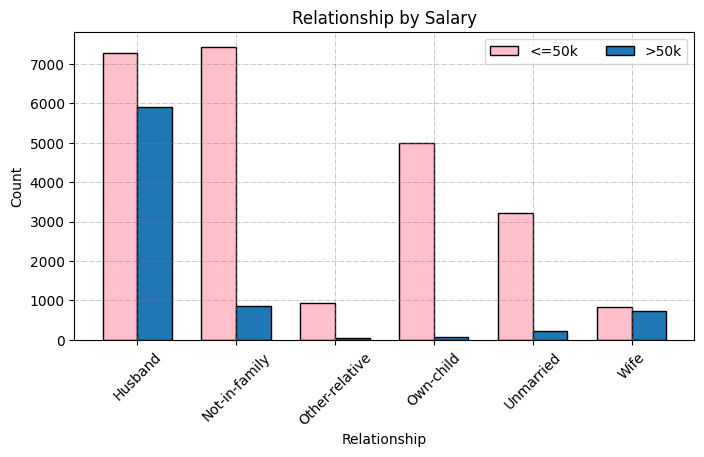

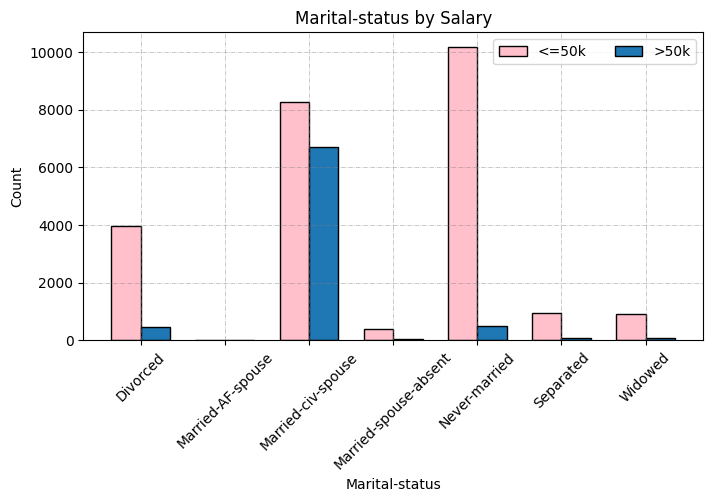

In [62]:
def plot_bar_relation(
    target_name,
    feature_name,
    dataframe,
    bar_width=0.35):
    
    class_0_df = dataframe[dataframe[target_name]=="<=50K"]
    class_1_df = dataframe[dataframe[target_name]==">50K"]
    
    feature_class_0 = class_0_df[feature_name].value_counts().sort_index()
    feature_class_1 = class_1_df[feature_name].value_counts().sort_index()
    
    index = feature_class_0.index
    classes = np.arange(len(index))
    
    fig, ax = plt.subplots(figsize=(8,4))
    bar_0 = ax.bar(classes, feature_class_0, bar_width, label="<=50k", color="pink", edgecolor='black')
    bar_1 = ax.bar(classes+bar_width, feature_class_1, bar_width, label=">50k", edgecolor='black')
    
    ax.set_title(f"{feature_name.capitalize()} by Salary")
    
    ax.set_xlabel(f"{feature_name.capitalize()}")
    ax.set_xticklabels(index, rotation=45)
    ax.set_xticks(classes + bar_width / 2)
    
    ax.set_ylabel("Count")
    ax.legend(ncols=2)
    
    plt.grid(color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.6)
    
    plt.show();


plot_relation_list = ["race", "sex", 
                    "relationship", "marital-status"]

for target_name in plot_relation_list:
    plot_bar_relation(
        target_name="salary",
        feature_name=target_name,
        dataframe=raw_df
    )
    

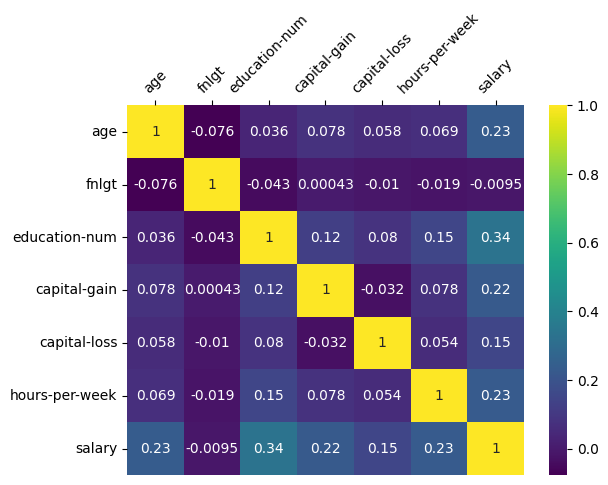

In [63]:
raw_df['salary'] = raw_df['salary'].replace({'<=50K': 0, '>50K': 1})

numerical_cols = []
for col in raw_df.columns.tolist():
    if raw_df[col].dtype in ["int64"]:
        numerical_cols.append(col)
    
ax = sns.heatmap(raw_df[numerical_cols].corr(), 
                annot = True, 
                cmap=sns.color_palette("viridis", as_cmap=True))

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(labels=numerical_cols, rotation=45);

Salary has 34% correlation with Education_num, 23% correlation with hours_per_week and age, and 22% correlation with Capital_gain. The correlations are moderate.

### **Data Modeling**

Replace Missing Values

In [64]:
raw_df['workclass'] = raw_df['workclass'].replace("?", "Private")
raw_df['occupation'] = raw_df['occupation'].replace("?", "Prof-speciality")
raw_df['native-country'] = raw_df['native-country'].replace("?", "United-States")

Combining the data logically to reduce categories 

In [65]:
workclass_mapping = {
    "Never-worked": "Without-pay",
    "State-gov": "Gov",
    "Local-gov": "Gov",
    "Self-emp-not-inc": "Without-pay"
}

# Use replace() with the mapping dictionary
raw_df['workclass'] = raw_df['workclass'].replace(workclass_mapping)

In [66]:
education_mapping = {
    "11th": "School",
    "10th": "School",
    "7th-8th": "School",
    "9th": "School",
    "12th": "School",
    "5th-6th": "School",
    "1st-4th": "School",
    "Preschool": "School",
    "HS-grad": "College",
    "Some-college": "College",
    "Prof-school": "Doctorate",
    "Doctorate": "Doctorate",
    "Assoc-voc": "Assoc",
    "Assoc-acdm": "Assoc"
}

# Use replace() with the mapping dictionary
raw_df['education'] = raw_df['education'].replace(education_mapping)

In [67]:
martial_mapping = {
    "Divorced": "No spouse",
    "Married-spouse-absent": "No spouse",
    "Separated": "No spouse", 
    "Widowed": "No spouse",
    "Married-AF-Spouse": "No spouse"
}

# Use replace() with the mapping dictionary
raw_df['marital-status'] = raw_df['marital-status'].replace(martial_mapping)

In [68]:
relationship_mapping = {
    "Not-in-family": "Other",
    "Own-child": "Other",
    "Unmarried": "Other",
    "Other-relative": "Other"
}

raw_df["relationship"] = raw_df["relationship"].replace(relationship_mapping)

In [69]:
race_mapping = {
    "Amer-Indian-Eskimo": "Others",
    "Other": "Others"
}

raw_df["race"] = raw_df["race"].replace(race_mapping)

### **Outliers Detection - Skewness Treatment**

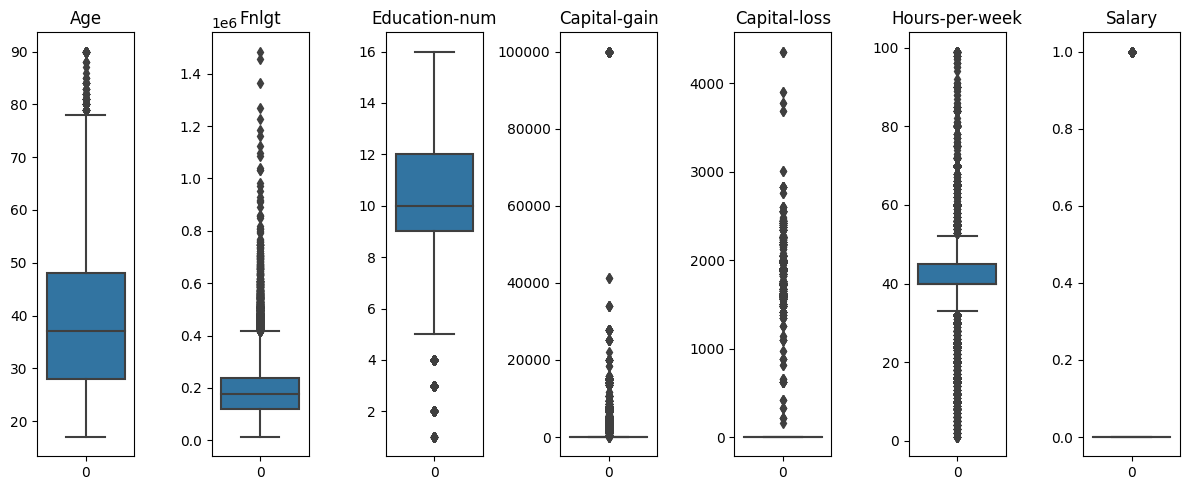

In [70]:
# Outliers Detection - Boxplot

fig, ax = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(12, 5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data = raw_df[col], ax=ax[i])
    ax[i].set_title(f"{col.capitalize()}")

plt.tight_layout()

Can also use the Z-score and boxplot to handle the outliers

In [71]:
# np.sqrt(raw_df[numerical_cols]).skew()

np.cbrt(raw_df[numerical_cols]).skew()

age               0.089933
fnlgt            -0.163654
education-num    -1.325775
capital-gain      4.097819
capital-loss      4.335231
hours-per-week   -1.450953
salary            1.211687
dtype: float64

### **Encoding Data**

In [72]:
import copy
from sklearn.preprocessing import LabelEncoder

In [73]:
le = LabelEncoder()
processed_df = copy.deepcopy(raw_df)

In [76]:
for col in processed_df.columns.tolist():
    processed_df[col] = le.fit_transform(processed_df[col])

LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()
LabelEncoder()


In [30]:
processed_df.relationship.value_counts()

relationship
1    17782
0    13187
2     1568
Name: count, dtype: int64

In [31]:
processed_df.sample(3)

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
9351,47,2,12050,5,6,2,9,1,3,1,0,0,39,38,0
21594,6,2,17897,2,9,2,0,1,3,1,0,0,44,38,0
21346,10,2,13494,2,8,1,5,0,3,1,0,0,61,38,0


### **Data Scaling**

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [33]:
X = processed_df.drop("salary", axis = 1)
Y = processed_df["salary"]

In [34]:
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.sample(3)

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
13180,0.030495,-0.037718,1.362833,-0.157037,-0.420679,-0.958750,-0.797719,-1.126053,0.395889,0.703020,-0.279134,-0.204255,1.615665,0.261131
16295,-0.409615,-0.037718,-0.194046,1.318423,1.523641,1.598415,-0.797719,0.625471,0.395889,-1.422436,4.225786,-0.204255,0.792154,0.261131
5447,-1.436538,-0.037718,0.827341,-0.157037,-0.420679,0.319832,-0.338746,0.625471,0.395889,-1.422436,-0.279134,-0.204255,-1.266623,0.261131


In [78]:
y[:5]

array([0, 0, 0, 0, 0])

### **Fitting to Model**

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn. linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [36]:
decision_tree = DecisionTreeClassifier()
gauss_nb = GaussianNB()
lr = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier()

In [37]:
# Fitting Data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=13)
for model in [decision_tree, gauss_nb, lr, svc, knn]:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    test_score = accuracy_score(y_test, pred)
    train_score = accuracy_score(y_train, model.predict(x_train))
    print(model)
    print(f"Accuracy train score: {train_score}")
    print(f"Accuracy test score: {test_score}")
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    print("--------------------------")

DecisionTreeClassifier()
Accuracy train score: 1.0
Accuracy test score: 0.8101823396844909
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7415
           1       0.60      0.61      0.61      2347

    accuracy                           0.81      9762
   macro avg       0.74      0.74      0.74      9762
weighted avg       0.81      0.81      0.81      9762

[[6475  940]
 [ 913 1434]]
--------------------------
GaussianNB()
Accuracy train score: 0.8161141602634467
Accuracy test score: 0.8148944888342553
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      7415
           1       0.65      0.51      0.57      2347

    accuracy                           0.81      9762
   macro avg       0.75      0.71      0.73      9762
weighted avg       0.80      0.81      0.81      9762

[[6757  658]
 [1149 1198]]
--------------------------
LogisticRegression()
Accuracy train score: 0.83824368

In [38]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [39]:
random_forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
gradient_boosting = GradientBoostingClassifier()

In [40]:
# Fitting Data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=13)
for model in [random_forest, adaboost, gradient_boosting]:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    test_score = accuracy_score(y_test, pred)
    train_score = accuracy_score(y_train, model.predict(x_train))
    print(model)
    print(f"Accuracy train score: {train_score}")
    print(f"Accuracy test score: {test_score}")
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    print("--------------------------")

RandomForestClassifier()
Accuracy train score: 1.0
Accuracy test score: 0.8557672608072117
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7415
           1       0.74      0.61      0.67      2347

    accuracy                           0.86      9762
   macro avg       0.81      0.77      0.79      9762
weighted avg       0.85      0.86      0.85      9762

[[6914  501]
 [ 907 1440]]
--------------------------
AdaBoostClassifier()
Accuracy train score: 0.8616904500548848
Accuracy test score: 0.8574062692071297
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7415
           1       0.76      0.59      0.66      2347

    accuracy                           0.86      9762
   macro avg       0.82      0.77      0.79      9762
weighted avg       0.85      0.86      0.85      9762

[[6989  426]
 [ 966 1381]]
--------------------------
GradientBoostingClassifier()
Accuracy train s

We see that the Gradient Boosting Classifier gives us an accuracy of ~87% (higher than SVC), and the f1-score, recall and precision scores also improve. Hence we choose ‘Gradient boosting classifier’ as our final model, and proceed with hypertuning the model. But before this, we perform k-folds cross validation on our dataset.

In [41]:
# Cross Validation
from sklearn.model_selection import cross_val_score

In [42]:
for i in range(2, 9):
    cv = cross_val_score(gradient_boosting, X, Y, cv=i)
    print(gradient_boosting, cv.mean())

GradientBoostingClassifier() 0.8662753786033052
GradientBoostingClassifier() 0.8660295281658263
GradientBoostingClassifier() 0.8658758398243074
GradientBoostingClassifier() 0.8666136293674185
GradientBoostingClassifier() 0.8664290181359099
GradientBoostingClassifier() 0.8662755045185019
GradientBoostingClassifier() 0.865660938558883


This helps us interpret that the model is not overfitting and will perform well for new data that we feed to our model. We now proceed with hypertuning the model, using GridSearch CV.

In [43]:
params = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 4, 5],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3],
    "n_estimators": [10, 50, 100],
}

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
gcv = GridSearchCV(gradient_boosting, param_grid=params)
res = gcv.fit(x_train, y_train)
res.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [46]:
# Savemodel

import joblib

In [50]:
final_model = GradientBoostingClassifier(**res.best_params_)
final_model.fit(x_train, y_train)
pred = final_model.predict(x_test)
test_score = accuracy_score(y_test, pred)
train_score = accuracy_score(y_train, model.predict(x_train))
print(model)
print(f"Accuracy train score: {train_score}")
print(f"Accuracy test score: {test_score}")
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print("--------------------------")

GradientBoostingClassifier()
Accuracy train score: 0.8702524698133919
Accuracy test score: 0.8700061462814997
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7415
           1       0.78      0.64      0.70      2347

    accuracy                           0.87      9762
   macro avg       0.84      0.79      0.81      9762
weighted avg       0.87      0.87      0.87      9762

[[6998  417]
 [ 852 1495]]
--------------------------


In [48]:
# joblib.dump(final_model, "census_income.obj")

In [49]:
raw_df.to_csv(CLEANED_DATA_PATH, index=False)

### **Test**

In [15]:
import pandas as pd
import joblib
from collections import defaultdict
from sklearn import preprocessing 

df = pd.read_csv("../data/cleaned_census.csv")
df = df.iloc[13:14, :]
df

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
13,32,Private,205019,Assoc,12,Never-married,Sales,Other,Black,Male,0,0,50,United-States,<=50K


In [2]:
import yaml

with open("../utils/constants.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

cat_cols = config["CAT_FEATURES"]

In [24]:
le_dict = joblib.load("../model/label_encoder_dict.joblib")

In [25]:
le_dict

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'workclass': LabelEncoder(),
             'education': LabelEncoder(),
             'marital-status': LabelEncoder(),
             'occupation': LabelEncoder(),
             'relationship': LabelEncoder(),
             'race': LabelEncoder(),
             'sex': LabelEncoder(),
             'native-country': LabelEncoder(),
             'salary': LabelEncoder()})

In [13]:
df.columns

Index(['pets', 'owner', 'location'], dtype='object')

In [23]:
fit = df.apply(lambda x: le_dict[x.name].transform(x) 
                                if x.name in cat_cols else x)

fit

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
13,32,2,205019,0,12,2,12,1,1,1,0,0,50,38,0


In [26]:
for i in le_dict:
    print(i)
    print(dict(zip(le_dict[i].classes_, le_dict[i].transform(le_dict[i].classes_))))

workclass
{'Federal-gov': 0, 'Gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Without-pay': 4}
education
{'Assoc': 0, 'Bachelors': 1, 'College': 2, 'Doctorate': 3, 'Masters': 4, 'School': 5}
marital-status
{'Married-AF-spouse': 0, 'Married-civ-spouse': 1, 'Never-married': 2, 'No spouse': 3}
occupation
{'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-speciality': 9, 'Prof-specialty': 10, 'Protective-serv': 11, 'Sales': 12, 'Tech-support': 13, 'Transport-moving': 14}
relationship
{'Husband': 0, 'Other': 1, 'Wife': 2}
race
{'Asian-Pac-Islander': 0, 'Black': 1, 'Others': 2, 'White': 3}
sex
{'Female': 0, 'Male': 1}
native-country
{'Cambodia': 0, 'Canada': 1, 'China': 2, 'Columbia': 3, 'Cuba': 4, 'Dominican-Republic': 5, 'Ecuador': 6, 'El-Salvador': 7, 'England': 8, 'France': 9, 'Germany': 10, 'Greece': 11, 'Guatemala': 12, 'Haiti': 13, 'Holand-Nethe